In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 59 kB 5.6 MB/s 
     |████████████████████████████████| 596 kB 50.5 MB/s 
     |████████████████████████████████| 3.3 MB 36.8 MB/s 
     |████████████████████████████████| 895 kB 40.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler 
from transformers import AutoTokenizer
from sklearn.model_selection import KFold

data = []
label = []

f = open('dataset_1192.txt')
record = f.read().split('\n')
for r in record:
    data.append(r.split('\t')[0])
    label.append(r.split('\t')[1])
    
df = pd.DataFrame({'Data':data,'Label':label})
texts = list(df.Data)
label = np.array(df.Label.astype('int'))
number_label = df.Label.astype('category').cat.categories


In [3]:
training_sizes = [200,400,600,800,1000,1192]
Xs=[]
Ys=[]
for s in training_sizes :
  Xs.append(texts[0:s])
  Ys.append(label[0:s])

In [5]:
from transformers import AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from transformers import AutoConfig
from transformers import AdamW
from sklearn.metrics import f1_score
import random
import numpy as np
import os
import time
import datetime
import random


data_set = 1 
training_f1_stats = []
validation_f1_stats = []
training_accuracy_stats = [] 
validation_accuracy_stats = []
training_time_stats = []
validation_time_stats = []
# "bert-base-cased"
# "distilbert-base-uncased"
# "dmis-lab/biobert-v1.1" 


for xx,yy in zip(Xs,Ys):
  kf = KFold(n_splits=3)
  batch_size = 10
  train_dataset_index = []
  test_dataset_index = []
  for train_index, test_index in kf.split(xx):
    train_dataset_index.append(train_index)
    test_dataset_index.append(test_index)

  #Tokenize Data
  model_name = "dmis-lab/biobert-v1.1" 
  MAX_INPUT_LENGTH = 319
  tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
  inputs = tokenizer(xx, padding=True, max_length= MAX_INPUT_LENGTH ,return_tensors="pt")
  labels = torch.tensor(yy, dtype=torch.long)

  #Train
  train_set1 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(train_dataset_index[0])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(train_dataset_index[0])), 
  labels[train_dataset_index[0]])

  train_set2 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(train_dataset_index[1])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(train_dataset_index[1])), 
  labels[train_dataset_index[1]])

  train_set3 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(train_dataset_index[2])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(train_dataset_index[2])), 
  labels[train_dataset_index[2]])

  #test
  test_set1 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(test_dataset_index[0])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(test_dataset_index[0])), 
  labels[test_dataset_index[0]])

  test_set2 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(test_dataset_index[1])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(test_dataset_index[1])), 
  labels[test_dataset_index[1]])

  test_set3 = TensorDataset(torch.index_select(inputs.input_ids, 0, torch.tensor(test_dataset_index[2])), 
  torch.index_select(inputs.attention_mask, 0, torch.tensor(test_dataset_index[2])), 
  labels[test_dataset_index[2]])

  #train DataLoader
  train_loader1 = DataLoader(
              train_set1 ,
              sampler = RandomSampler(train_set1 ),
              batch_size = batch_size
          )

  train_loader2 = DataLoader(
              train_set2 ,
              sampler = RandomSampler(train_set2 ),
              batch_size = batch_size
          )

  train_loader3 = DataLoader(
              train_set3 ,
              sampler = RandomSampler(train_set3 ),
              batch_size = batch_size
          )
  
  #test DataLoader
  test_loader1 = DataLoader(
              test_set1 ,
              sampler = RandomSampler(test_set1 ),
              batch_size = batch_size
          )

  test_loader2 = DataLoader(
              test_set2 ,
              sampler = RandomSampler(test_set2 ),
              batch_size = batch_size
          )

  test_loader3 = DataLoader(
              test_set3 ,
              sampler = RandomSampler(test_set3 ),
              batch_size = batch_size
          )
  
  train_set = [train_loader1,train_loader2,train_loader3]
  test_set = [test_loader1,test_loader2,test_loader3]

  iter = 0 #counter
  
  total_t0 = time.time()
  training_row_f1 = []
  validation_row_f1 = []
  training_row_accuracy = []
  validation_row_accuracy = []
  training_row_time = []
  validation_row_time = []

  for train, test in zip(train_set,test_set):
    iter += 1
    # Download the pre-trained model
    config = AutoConfig.from_pretrained(model_name)
    config.num_labels = len(number_label)
    config.output_attentions = True
    config.return_dict=False
    config.finetuning_task="SST-2"

    # Number of training epochs. The BERT authors recommend between 2 and 4. 
    epochs = 3
    total_steps = len(test) * epochs

    def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

    def flat_f1_score(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()  
        return f1_score(labels_flat, pred_flat, average = 'weighted')

    def format_time(elapsed):
        '''
        Takes a time in seconds and returns a string hh:mm:ss
        '''
        # Round to the nearest second.
        elapsed_rounded = int(round((elapsed)))
        
        # Format as hh:mm:ss
        return str(datetime.timedelta(seconds=elapsed_rounded))   
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    model = AutoModelForSequenceClassification.from_pretrained(model_name,config=config)
    # Tell pytorch to run this model on the GPU.
    model.cuda()
    torch.cuda.empty_cache()

    optimizer = AdamW(model.parameters(),
                      lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                      eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                    )

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)


    # If there's a GPU available...
    if torch.cuda.is_available():    
        # Tell PyTorch to use the GPU.    
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))

    # If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")




    epoch_training_row_f1 = []
    epoch_validation_row_f1 = []
    epoch_training_row_accuracy = []
    epoch_validation_row_accuracy = []
    epoch_training_row_time = []
    epoch_validation_row_time = []

    # For each epoch...
    for epoch_i in range(0, epochs):

       

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure training time
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0
      total_train_accuracy = 0
      total_train_f1 = 0
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train), elapsed))
          # Unpack elements in DataLoader and copy each tensors to the GPU
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # clear any previously calculated gradients
          model.zero_grad()        

          loss, logits, attentions = model(input_ids=b_input_ids, 
                                          attention_mask=b_input_mask, 
                                          labels=b_labels)
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of train sentences, and
          # accumulate it over all batches.
          total_train_accuracy += flat_accuracy(logits, label_ids)
          total_train_f1 += flat_f1_score(logits, label_ids)

      # Report the final accuracy for this training run.
      avg_train_accuracy = total_train_accuracy / len(train)
      # Report the final f1_score for this training run.
      avg_train_f1 =  total_train_f1 / len(train)
      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train)            
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      #count
      print(" Dataset: {0:.2f}  Cross Validation Round: {1:.2f}".format(data_set,iter))
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training F1-Score: {0:.2f}".format(avg_train_f1))
      print("  Training Accuracy: {0:.2f}".format(avg_train_accuracy))   
      print("  Training epoch took: {:}".format(training_time))

      epoch_training_row_f1.append(avg_train_f1)
      epoch_training_row_accuracy.append(avg_train_accuracy)
      epoch_training_row_time.append(training_time)

      ### Validation
      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      total_eval_f1 = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in test:
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          with torch.no_grad():        
              (loss, logits, attentions) = model(input_ids=b_input_ids, 
                                                attention_mask=b_input_mask,
                                                labels=b_labels)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          total_eval_f1 += flat_f1_score(logits, label_ids)


      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(test)
      # Report the final f1_score for this validation run.
      avg_val_f1 =  total_eval_f1 / len(test)
      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(test)
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)


      #count
      epoch_validation_row_f1.append(avg_val_f1)
      epoch_validation_row_accuracy.append(avg_val_accuracy)
      epoch_validation_row_time.append(validation_time)
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation F1-Score: {0:.2f}".format(avg_val_f1))
      print("  Validation Accuracy: {0:.2f}".format(avg_val_accuracy))     
      print("  Validation took: {:}".format(validation_time))

    training_row_f1.append(epoch_training_row_f1[-1])
    validation_row_f1.append(epoch_validation_row_f1[-1])
    training_row_accuracy.append(epoch_training_row_accuracy[-1])
    validation_row_accuracy.append(epoch_validation_row_accuracy[-1])
    training_row_time.append(epoch_training_row_time[-1])
    validation_row_time.append(epoch_validation_row_time[-1])

  training_f1_stats.append(training_row_f1)
  validation_f1_stats.append(validation_row_f1)
  training_accuracy_stats.append(training_row_accuracy)
  validation_accuracy_stats.append(validation_row_accuracy)
  training_time_stats.append(training_row_time)
  validation_time_stats.append(validation_row_time)

  data_set += 1


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2229: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
 Dataset: 1.00  Cross Validation Round: 1.00
  Average training loss: 1.15
  Training F1-Score: 0.60
  Training Accuracy: 0.68
  Training epoch took: 0:00:14

Running Validation...
  Validation Loss: 1.05
  Validation F1-Score: 0.58
  Validation Accuracy: 0.70
  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...
 Dataset: 1.00  Cross Validation Round: 1.00
  Average training loss: 1.05
  Training F1-Score: 0.57
  Training Accuracy: 0.66
  Training epoch took: 0:00:14

Running Validation...
  Validation Loss: 1.02
  Validation F1-Score: 0.58
  Validation Accuracy: 0.69
  Validation took: 0:00:03

======== Epoch 3 / 3 ========
Training...
 Dataset: 1.00  Cross Validation Round: 1.00
  Average training loss: 1.01
  Training F1-Score: 0.59
  Training Accuracy: 0.69
  Training epoch took: 0:00:14

Running Validation...
  Validation Loss: 1.00
  Validation F1-Score: 0.59
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
 Dataset: 1.00  Cross Validation Round: 2.00
  Average training loss: 1.16
  Training F1-Score: 0.62
  Training Accuracy: 0.68
  Training epoch took: 0:00:14

Running Validation...
  Validation Loss: 1.09
  Validation F1-Score: 0.52
  Validation Accuracy: 0.64
  Validation took: 0:00:03

======== Epoch 2 / 3 ========
Training...
 Dataset: 1.00  Cross Validation Round: 2.00
  Average training loss: 0.97
  Training F1-Score: 0.58
  Training Accuracy: 0.70
  Training epoch took: 0:00:14

Running Validation...
  Validation Loss: 1.05
  Validation F1-Score: 0.52
  Validation Accuracy: 0.65
  Validation took: 0:00:03

======== Epoch 3 / 3 ========
Training...
 Dataset: 1.00  Cross Validation Round: 2.00
  Average training loss: 0.95
  Training F1-Score: 0.62
  Training Accuracy: 0.72
  Training epoch took: 0:00:14

Running Validation...
  Validation Loss: 1.05
  Validation F1-Score: 0.52
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
 Dataset: 1.00  Cross Validation Round: 3.00
  Average training loss: 1.16
  Training F1-Score: 0.53
  Training Accuracy: 0.61
  Training epoch took: 0:00:14

Running Validation...
  Validation Loss: 1.03
  Validation F1-Score: 0.59
  Validation Accuracy: 0.70
  Validation took: 0:00:03

======== Epoch 2 / 3 ========
Training...
 Dataset: 1.00  Cross Validation Round: 3.00
  Average training loss: 0.97
  Training F1-Score: 0.54
  Training Accuracy: 0.66
  Training epoch took: 0:00:14

Running Validation...
  Validation Loss: 0.99
  Validation F1-Score: 0.58
  Validation Accuracy: 0.70
  Validation took: 0:00:03

======== Epoch 3 / 3 ========
Training...
 Dataset: 1.00  Cross Validation Round: 3.00
  Average training loss: 0.97
  Training F1-Score: 0.55
  Training Accuracy: 0.67
  Training epoch took: 0:00:14

Running Validation...
  Validation Loss: 0.98
  Validation F1-Score: 0.61
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
 Dataset: 2.00  Cross Validation Round: 1.00
  Average training loss: 1.05
  Training F1-Score: 0.56
  Training Accuracy: 0.67
  Training epoch took: 0:00:28

Running Validation...
  Validation Loss: 0.84
  Validation F1-Score: 0.58
  Validation Accuracy: 0.69
  Validation took: 0:00:05

======== Epoch 2 / 3 ========
Training...
 Dataset: 2.00  Cross Validation Round: 1.00
  Average training loss: 0.78
  Training F1-Score: 0.65
  Training Accuracy: 0.72
  Training epoch took: 0:00:28

Running Validation...
  Validation Loss: 0.75
  Validation F1-Score: 0.71
  Validation Accuracy: 0.76
  Validation took: 0:00:05

======== Epoch 3 / 3 ========
Training...
 Dataset: 2.00  Cross Validation Round: 1.00
  Average training loss: 0.75
  Training F1-Score: 0.68
  Training Accuracy: 0.75
  Training epoch took: 0:00:28

Running Validation...
  Validation Loss: 0.77
  Validation F1-Score: 0.70
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
 Dataset: 2.00  Cross Validation Round: 2.00
  Average training loss: 1.06
  Training F1-Score: 0.55
  Training Accuracy: 0.66
  Training epoch took: 0:00:28

Running Validation...
  Validation Loss: 0.85
  Validation F1-Score: 0.58
  Validation Accuracy: 0.70
  Validation took: 0:00:05

======== Epoch 2 / 3 ========
Training...
 Dataset: 2.00  Cross Validation Round: 2.00
  Average training loss: 0.81
  Training F1-Score: 0.56
  Training Accuracy: 0.68
  Training epoch took: 0:00:28

Running Validation...
  Validation Loss: 0.81
  Validation F1-Score: 0.57
  Validation Accuracy: 0.66
  Validation took: 0:00:05

======== Epoch 3 / 3 ========
Training...
 Dataset: 2.00  Cross Validation Round: 2.00
  Average training loss: 0.80
  Training F1-Score: 0.57
  Training Accuracy: 0.68
  Training epoch took: 0:00:28

Running Validation...
  Validation Loss: 0.77
  Validation F1-Score: 0.60
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
 Dataset: 2.00  Cross Validation Round: 3.00
  Average training loss: 1.09
  Training F1-Score: 0.56
  Training Accuracy: 0.66
  Training epoch took: 0:00:28

Running Validation...
  Validation Loss: 0.93
  Validation F1-Score: 0.55
  Validation Accuracy: 0.67
  Validation took: 0:00:05

======== Epoch 2 / 3 ========
Training...
 Dataset: 2.00  Cross Validation Round: 3.00
  Average training loss: 0.84
  Training F1-Score: 0.56
  Training Accuracy: 0.68
  Training epoch took: 0:00:28

Running Validation...
  Validation Loss: 0.83
  Validation F1-Score: 0.59
  Validation Accuracy: 0.70
  Validation took: 0:00:05

======== Epoch 3 / 3 ========
Training...
 Dataset: 2.00  Cross Validation Round: 3.00
  Average training loss: 0.81
  Training F1-Score: 0.57
  Training Accuracy: 0.69
  Training epoch took: 0:00:28

Running Validation...
  Validation Loss: 0.83
  Validation F1-Score: 0.59
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
 Dataset: 3.00  Cross Validation Round: 1.00
  Average training loss: 1.00
  Training F1-Score: 0.56
  Training Accuracy: 0.66
  Training epoch took: 0:00:42

Running Validation...
  Validation Loss: 0.72
  Validation F1-Score: 0.75
  Validation Accuracy: 0.74
  Validation took: 0:00:08

======== Epoch 2 / 3 ========
Training...
 Dataset: 3.00  Cross Validation Round: 1.00
  Average training loss: 0.69
  Training F1-Score: 0.74
  Training Accuracy: 0.77
  Training epoch took: 0:00:42

Running Validation...
  Validation Loss: 0.66
  Validation F1-Score: 0.75
  Validation Accuracy: 0.75
  Validation took: 0:00:08

======== Epoch 3 / 3 ========
Training...
 Dataset: 3.00  Cross Validation Round: 1.00
  Average training loss: 0.66
  Training F1-Score: 0.75
  Training Accuracy: 0.78
  Training epoch took: 0:00:42

Running Validation...
  Validation Loss: 0.66
  Validation F1-Score: 0.74
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
 Dataset: 3.00  Cross Validation Round: 2.00
  Average training loss: 0.99
  Training F1-Score: 0.58
  Training Accuracy: 0.65
  Training epoch took: 0:00:42

Running Validation...
  Validation Loss: 0.67
  Validation F1-Score: 0.78
  Validation Accuracy: 0.81
  Validation took: 0:00:08

======== Epoch 2 / 3 ========
Training...
 Dataset: 3.00  Cross Validation Round: 2.00
  Average training loss: 0.69
  Training F1-Score: 0.76
  Training Accuracy: 0.79
  Training epoch took: 0:00:42

Running Validation...
  Validation Loss: 0.63
  Validation F1-Score: 0.78
  Validation Accuracy: 0.80
  Validation took: 0:00:08

======== Epoch 3 / 3 ========
Training...
 Dataset: 3.00  Cross Validation Round: 2.00
  Average training loss: 0.68
  Training F1-Score: 0.75
  Training Accuracy: 0.78
  Training epoch took: 0:00:42

Running Validation...
  Validation Loss: 0.63
  Validation F1-Score: 0.79
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
 Dataset: 3.00  Cross Validation Round: 3.00
  Average training loss: 0.99
  Training F1-Score: 0.57
  Training Accuracy: 0.67
  Training epoch took: 0:00:42

Running Validation...
  Validation Loss: 0.90
  Validation F1-Score: 0.45
  Validation Accuracy: 0.59
  Validation took: 0:00:08

======== Epoch 2 / 3 ========
Training...
 Dataset: 3.00  Cross Validation Round: 3.00
  Average training loss: 0.70
  Training F1-Score: 0.69
  Training Accuracy: 0.75
  Training epoch took: 0:00:42

Running Validation...
  Validation Loss: 0.78
  Validation F1-Score: 0.69
  Validation Accuracy: 0.74
  Validation took: 0:00:08

======== Epoch 3 / 3 ========
Training...
 Dataset: 3.00  Cross Validation Round: 3.00
  Average training loss: 0.69
  Training F1-Score: 0.74
  Training Accuracy: 0.78
  Training epoch took: 0:00:42

Running Validation...
  Validation Loss: 0.78
  Validation F1-Score: 0.69
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
  Batch    40  of     54.    Elapsed: 0:00:42.
 Dataset: 4.00  Cross Validation Round: 1.00
  Average training loss: 0.92
  Training F1-Score: 0.60
  Training Accuracy: 0.67
  Training epoch took: 0:00:56

Running Validation...
  Validation Loss: 0.64
  Validation F1-Score: 0.77
  Validation Accuracy: 0.76
  Validation took: 0:00:10

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     54.    Elapsed: 0:00:42.
 Dataset: 4.00  Cross Validation Round: 1.00
  Average training loss: 0.60
  Training F1-Score: 0.76
  Training Accuracy: 0.80
  Training epoch took: 0:00:56

Running Validation...
  Validation Loss: 0.59
  Validation F1-Score: 0.78
  Validation Accuracy: 0.77
  Validation took: 0:00:10

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     54.    Elapsed: 0:00:42.
 Dataset: 4.00  Cross Validation Round: 1.00
  Average training loss: 0.59
  Training F1-Scor

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
  Batch    40  of     54.    Elapsed: 0:00:42.
 Dataset: 4.00  Cross Validation Round: 2.00
  Average training loss: 0.95
  Training F1-Score: 0.60
  Training Accuracy: 0.69
  Training epoch took: 0:00:56

Running Validation...
  Validation Loss: 0.70
  Validation F1-Score: 0.77
  Validation Accuracy: 0.79
  Validation took: 0:00:10

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     54.    Elapsed: 0:00:42.
 Dataset: 4.00  Cross Validation Round: 2.00
  Average training loss: 0.63
  Training F1-Score: 0.78
  Training Accuracy: 0.82
  Training epoch took: 0:00:56

Running Validation...
  Validation Loss: 0.63
  Validation F1-Score: 0.77
  Validation Accuracy: 0.81
  Validation took: 0:00:10

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     54.    Elapsed: 0:00:42.
 Dataset: 4.00  Cross Validation Round: 2.00
  Average training loss: 0.63
  Training F1-Scor

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
  Batch    40  of     54.    Elapsed: 0:00:42.
 Dataset: 4.00  Cross Validation Round: 3.00
  Average training loss: 0.98
  Training F1-Score: 0.53
  Training Accuracy: 0.65
  Training epoch took: 0:00:56

Running Validation...
  Validation Loss: 0.83
  Validation F1-Score: 0.52
  Validation Accuracy: 0.64
  Validation took: 0:00:10

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     54.    Elapsed: 0:00:42.
 Dataset: 4.00  Cross Validation Round: 3.00
  Average training loss: 0.70
  Training F1-Score: 0.62
  Training Accuracy: 0.70
  Training epoch took: 0:00:56

Running Validation...
  Validation Loss: 0.75
  Validation F1-Score: 0.64
  Validation Accuracy: 0.72
  Validation took: 0:00:10

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     54.    Elapsed: 0:00:42.
 Dataset: 4.00  Cross Validation Round: 3.00
  Average training loss: 0.69
  Training F1-Scor

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:42.
 Dataset: 5.00  Cross Validation Round: 1.00
  Average training loss: 0.85
  Training F1-Score: 0.66
  Training Accuracy: 0.70
  Training epoch took: 0:01:10

Running Validation...
  Validation Loss: 0.49
  Validation F1-Score: 0.83
  Validation Accuracy: 0.85
  Validation took: 0:00:13

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:42.
 Dataset: 5.00  Cross Validation Round: 1.00
  Average training loss: 0.57
  Training F1-Score: 0.76
  Training Accuracy: 0.79
  Training epoch took: 0:01:10

Running Validation...
  Validation Loss: 0.46
  Validation F1-Score: 0.83
  Validation Accuracy: 0.85
  Validation took: 0:00:13

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:42.
 Dataset: 5.00  Cross Validation Round: 1.00
  Average training loss: 0.55
  Training F1-Scor

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:42.
 Dataset: 5.00  Cross Validation Round: 2.00
  Average training loss: 0.84
  Training F1-Score: 0.64
  Training Accuracy: 0.71
  Training epoch took: 0:01:10

Running Validation...
  Validation Loss: 0.67
  Validation F1-Score: 0.67
  Validation Accuracy: 0.73
  Validation took: 0:00:13

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:42.
 Dataset: 5.00  Cross Validation Round: 2.00
  Average training loss: 0.53
  Training F1-Score: 0.79
  Training Accuracy: 0.83
  Training epoch took: 0:01:10

Running Validation...
  Validation Loss: 0.55
  Validation F1-Score: 0.76
  Validation Accuracy: 0.80
  Validation took: 0:00:13

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:42.
 Dataset: 5.00  Cross Validation Round: 2.00
  Average training loss: 0.51
  Training F1-Scor

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:42.
 Dataset: 5.00  Cross Validation Round: 3.00
  Average training loss: 0.83
  Training F1-Score: 0.66
  Training Accuracy: 0.72
  Training epoch took: 0:01:10

Running Validation...
  Validation Loss: 0.73
  Validation F1-Score: 0.71
  Validation Accuracy: 0.71
  Validation took: 0:00:13

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:42.
 Dataset: 5.00  Cross Validation Round: 3.00
  Average training loss: 0.51
  Training F1-Score: 0.79
  Training Accuracy: 0.82
  Training epoch took: 0:01:10

Running Validation...
  Validation Loss: 0.63
  Validation F1-Score: 0.73
  Validation Accuracy: 0.75
  Validation took: 0:00:13

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:42.
 Dataset: 5.00  Cross Validation Round: 3.00
  Average training loss: 0.49
  Training F1-Scor

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:42.
 Dataset: 6.00  Cross Validation Round: 1.00
  Average training loss: 0.90
  Training F1-Score: 0.59
  Training Accuracy: 0.67
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.55
  Validation F1-Score: 0.81
  Validation Accuracy: 0.83
  Validation took: 0:00:15

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:42.
 Dataset: 6.00  Cross Validation Round: 1.00
  Average training loss: 0.59
  Training F1-Score: 0.77
  Training Accuracy: 0.80
  Training epoch took: 0:01:23

Running Validation...
  Validation Loss: 0.51
  Validation F1-Score: 0.82
  Validation Accuracy: 0.84
  Validation took: 0:00:15

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:42.
 Dataset: 6.00  Cross Validation Round: 1.00
  Average training loss: 0.58
  Training F1-Scor

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:42.
 Dataset: 6.00  Cross Validation Round: 2.00
  Average training loss: 0.81
  Training F1-Score: 0.68
  Training Accuracy: 0.72
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.55
  Validation F1-Score: 0.77
  Validation Accuracy: 0.81
  Validation took: 0:00:15

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:42.
 Dataset: 6.00  Cross Validation Round: 2.00
  Average training loss: 0.53
  Training F1-Score: 0.79
  Training Accuracy: 0.82
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.53
  Validation F1-Score: 0.77
  Validation Accuracy: 0.82
  Validation took: 0:00:15

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:42.
 Dataset: 6.00  Cross Validation Round: 2.00
  Average training loss: 0.52
  Training F1-Scor

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There are 1 GPU(s) available.
We will use the GPU: Tesla K80

======== Epoch 1 / 3 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:42.
 Dataset: 6.00  Cross Validation Round: 3.00
  Average training loss: 0.75
  Training F1-Score: 0.68
  Training Accuracy: 0.73
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.60
  Validation F1-Score: 0.77
  Validation Accuracy: 0.80
  Validation took: 0:00:15

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:42.
 Dataset: 6.00  Cross Validation Round: 3.00
  Average training loss: 0.48
  Training F1-Score: 0.80
  Training Accuracy: 0.83
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.60
  Validation F1-Score: 0.77
  Validation Accuracy: 0.81
  Validation took: 0:00:15

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     80.    Elapsed: 0:00:42.
 Dataset: 6.00  Cross Validation Round: 3.00
  Average training loss: 0.45
  Training F1-Scor

In [6]:
### From the cells above, these vectors are filled with measurement values ###

print(training_f1_stats)
print(validation_f1_stats)
print(training_accuracy_stats)
print(validation_accuracy_stats)
print(training_time_stats)
print(validation_time_stats)

[[0.5855821174623695, 0.6210181427496774, 0.5541068168157951], [0.6830514162480109, 0.5705770557335744, 0.5707415303803333], [0.747585044577885, 0.7520281340391632, 0.7426021686646687], [0.7569743724563984, 0.7650478832122277, 0.6545871963020227], [0.7616391361583357, 0.7929447880390537, 0.7979626938274872], [0.7633064088689085, 0.8007192476641004, 0.804297998430448]]
[[0.592397363803821, 0.5193790336647478, 0.6055580126787558], [0.6952275980322197, 0.6019153275345225, 0.5931313011034373], [0.7430397935397937, 0.7885062437562438, 0.6866582491725681], [0.7672903022903023, 0.7681716369531495, 0.6262213323376036], [0.8418411240816086, 0.7552831727096434, 0.7449000509294628], [0.8233834094826744, 0.7685612125969269, 0.7748303930546576]]
[[0.6904761904761905, 0.7214285714285715, 0.6714285714285715], [0.7506172839506172, 0.6835978835978836, 0.6857142857142858], [0.7849999999999999, 0.7849999999999997, 0.7824999999999996], [0.795679012345679, 0.8080246913580242, 0.7296296296296296], [0.801990

In [7]:
import numpy as np

#train
f1_train = np.array(training_f1_stats).mean(axis = 1)
std_train = np.array(training_f1_stats).std(axis = 1)/np.sqrt(3)

print('Train f1')
for a,s in zip(f1_train,std_train) :
  print('{0:.4f} ({1:.4f})'.format(a,s))

#Validation
f1_validation = np.array(validation_f1_stats).mean(axis = 1)
std_validation = np.array(validation_f1_stats).std(axis = 1)/np.sqrt(3)
print('validation f1')
for a,s in zip(f1_validation,std_validation) :

  print('{0:.4f} ({1:.4f})'.format(a,s))


#train
acc_train = np.array(training_accuracy_stats).mean(axis = 1)
std_train = np.array(training_accuracy_stats).std(axis = 1)/np.sqrt(3)
print('Train Accuracy')
for a,s in zip(acc_train,std_train) :
  
  print('{0:.4f} ({1:.4f})'.format(a,s))

#validation
acc_validation = np.array(validation_accuracy_stats).mean(axis = 1)
std_validation = np.array(validation_accuracy_stats).std(axis = 1)/np.sqrt(3)
print('Validation Accuracy')
for a,s in zip(acc_validation,std_validation) :
  
  print('{0:.4f} ({1:.4f})'.format(a,s))



Train f1
0.5869 (0.0158)
0.6081 (0.0306)
0.7474 (0.0022)
0.7255 (0.0290)
0.7842 (0.0093)
0.7894 (0.0107)
validation f1
0.5724 (0.0219)
0.6301 (0.0267)
0.7394 (0.0241)
0.7206 (0.0385)
0.7807 (0.0251)
0.7889 (0.0141)
Train Accuracy
0.6944 (0.0119)
0.7066 (0.0180)
0.7842 (0.0007)
0.7778 (0.0199)
0.8196 (0.0072)
0.8265 (0.0085)
Validation Accuracy
0.6912 (0.0164)
0.7202 (0.0112)
0.7633 (0.0152)
0.7644 (0.0214)
0.8070 (0.0203)
0.8198 (0.0074)


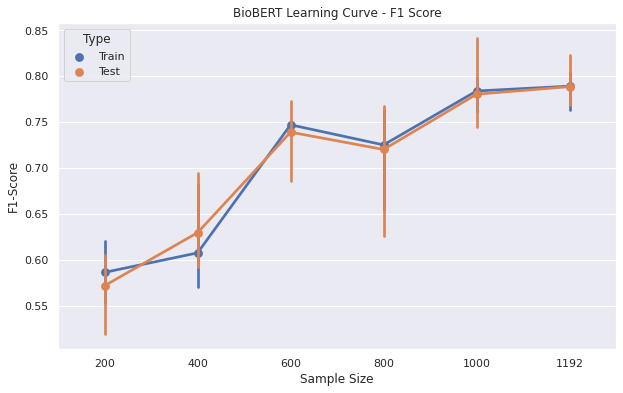

In [8]:

#### Comment these 2 following rows when fine-tuning the new model. Those are the record we have got. ####
# training_f1_stats = [[0.5873336957365042, 0.607044453408894, 0.5418140202549756], [0.629760541669822, 0.5624554474328008, 0.5660370835978563], [0.6804009386582915, 0.6988955570573218, 0.677194031659202], [0.703997855880524, 0.7139529774894124, 0.5982375728220529], [0.7229922141385722, 0.7438250805546677, 0.7488639847104102], [0.7061236796327739, 0.7550873568367761, 0.7622543676367205]]
# validation_f1_stats = [[0.5843910843689701, 0.5192204727145019, 0.5918206091580704], [0.659728568604066, 0.5835685151253484, 0.5770154350539136], [0.7487229491641257, 0.7833961587518089, 0.6214946476095857], [0.7793841581641145, 0.7700478307527795, 0.5875214509740366], [0.8337465878398769, 0.7262555598771679, 0.7310381485424738], [0.8156834023819318, 0.7694883251668966, 0.7712354806141569]]
##########################################################################################################


training_sizes= [200,400,600,800,1000,1192]

f_n_train = []
for n in training_sizes:
  for x in range(3):
    f_n_train.append(n)

f_train = []
for f in training_f1_stats:
  for ff in f:
    f_train.append(ff)

f_test = []
for f2 in validation_f1_stats:
  for ff2 in f2:
    f_test.append(ff2)

records = f_train + f_test
type1 = ['Train']*18
type2 = ['Test']*18
type_ = type1 + type2
n = f_n_train +f_n_train 

model = ['BioBERT']*(18*2)
measure = ['F1']*(18*2)

import pandas as pd
data_plot_f1 = pd.DataFrame({'n':n,'Data':records,'Type':type_,'Model':model,'Measure':measure})
data_plot_f1.to_excel('BioBERT_F1.xlsx' ,index = False)
## Construct Learning Curve ##
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

sns.set_theme(style="darkgrid")
ax = sns.pointplot(x="n", y="Data", hue="Type",data=data_plot_f1)
ax.set(xlabel='Sample Size', ylabel='F1-Score',title ="BioBERT Learning Curve - F1 Score",)
plt.savefig('BioBERT_F1_Learning_Curve.png')
plt.show()


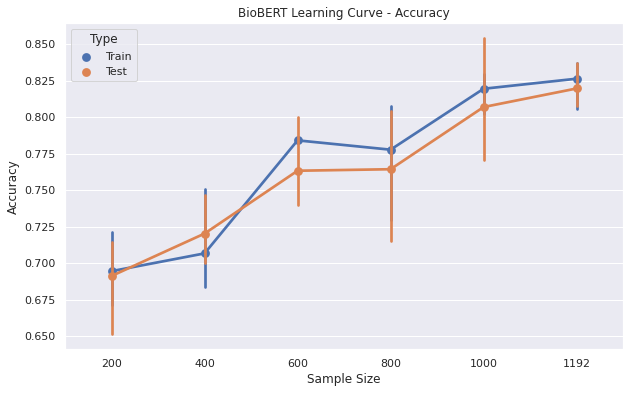

In [10]:
training_sizes= [200,400,600,800,1000,1192]

f_n_train = []
for n in training_sizes:
  for x in range(3):
    f_n_train.append(n)

f_train = []
for f in training_accuracy_stats:
  for ff in f:
    f_train.append(ff)

f_test = []
for f2 in validation_accuracy_stats:
  for ff2 in f2:
    f_test.append(ff2)

records = f_train + f_test
type1 = ['Train']*18
type2 = ['Test']*18
type_ = type1 + type2
n = f_n_train +f_n_train 

model = ['BioBERT']*(18*2)
measure = ['Accuracy']*(18*2)

import pandas as pd
data_plot_Accuracy = pd.DataFrame({'n':n,'Data':records,'Type':type_,'Model':model,'Measure':measure})
data_plot_Accuracy.to_excel('BioBERT_Accuracy.xlsx' ,index = False)


## Construct Learning Curve ##
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

sns.set_theme(style="darkgrid")
ax = sns.pointplot(x="n", y="Data", hue="Type",data=data_plot_Accuracy )
ax.set(xlabel='Sample Size', ylabel='Accuracy',title ="BioBERT Learning Curve - Accuracy",)
plt.savefig('BioBERT_Accuracy_Learning_Curve.png')
plt.show()